# Too many detections!

In [1]:
import argparse
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 
import networkx as nx

from tensorflow import keras
from tqdm import tqdm
from pathlib import Path

from astropy import units as u
from astropy.coordinates import SkyCoord
from tensorflow.keras.utils import pad_sequences
from dataloader import LSSTSourceDataSet, load, get_augmented_data, get_static_features, ts_length, get_ts_upto_days_since_trigger, ts_flag_value, static_flag_value, augment_ts_length_to_days_since_trigger
from loss import WHXE_Loss
from taxonomy import get_taxonomy_tree, source_node_label
from vizualizations import make_gif, plot_reliability_diagram, plot_data_set_composition, plot_day_vs_class_score, plot_lc, make_z_plots
from interpret_results import get_conditional_probabilites, save_all_cf_and_rocs, save_leaf_cf_and_rocs, save_all_phase_vs_accuracy_plot
from train_RNN import default_batch_size

from LSST_Source import LSST_Source

In [2]:
# This step takes a while because it has load from disc to memory...
print("Loading testing data from disc...")
test_dir = Path("processed/test")
X_ts = load(f"{test_dir}/x_ts.pkl")
X_static = load(f"{test_dir}/x_static.pkl")
Y = load(f"{test_dir}/y.pkl")
astrophysical_classes = load(f"{test_dir}/a_labels.pkl")

Loading testing data from disc...


In [3]:
for i in tqdm(range(len(X_static))):        
    X_static[i] = get_static_features(X_static[i])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 463528/463528 [00:02<00:00, 226730.37it/s]


In [4]:
max_class_count = 100000
X_ts_balanced = []
X_static_balanced = []
Y_balanced = []
astrophysical_classes_balanced = []

for c in np.unique(astrophysical_classes):

    idx = list(np.where(np.array(astrophysical_classes) == c)[0])
    
    if len(idx) > max_class_count:
        idx = random.sample(idx, max_class_count)

    X_ts_balanced += [X_ts[i] for i in idx]
    X_static_balanced += [X_static[i] for i in idx]
    Y_balanced += [Y[i] for i in idx]
    astrophysical_classes_balanced += [astrophysical_classes[i] for i in idx]


In [5]:
x1, x2, y_true, _ = augment_ts_length_to_days_since_trigger(X_ts_balanced, X_static_balanced, Y_balanced, astrophysical_classes_balanced, 1)

In [6]:
ras = np.array([a[8] for a in x2])
decs = np.array([a[9] for a in x2])
n_detections = np.array([sum(a) for a in x1[:, :, 1]])

In [7]:
threshold = 10

idx_threshold = np.where(n_detections>=threshold)[0]

In [8]:
LSST_DDF = {
    'ELAIS_S1': SkyCoord(l=311.30 * u.deg, b=-72.90 * u.deg, frame='galactic'),
    'XMM-LSS': SkyCoord(l=171.20 * u.deg, b=-58.77 * u.deg, frame='galactic'),
    'Extended_Chandra_Deep_Field-South': SkyCoord(l=224.07 * u.deg, b=-54.47 * u.deg, frame='galactic'),
    'COSMOS': SkyCoord(l=236.83 * u.deg, b=42.09 * u.deg, frame='galactic'),
}

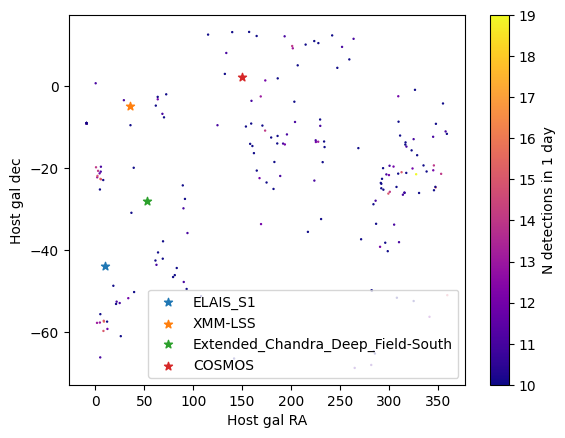

In [9]:
plt.scatter(ras[idx_threshold], decs[idx_threshold], c=n_detections[idx_threshold], marker='.', s=2, cmap="plasma")
plt.xlabel("Host gal RA")
plt.ylabel("Host gal dec")
plt.colorbar(label='N detections in 1 day')

for key in LSST_DDF:
    plt.scatter(LSST_DDF[key].fk5.ra, LSST_DDF[key].fk5.dec, marker="*", label=f"{key}")

plt.legend()
plt.savefig("n_detection_map.png")

In [10]:
np.array(astrophysical_classes_balanced)[idx_threshold]

array(['AGN', 'AGN', 'CART', 'Delta Scuti', 'Delta Scuti', 'Dwarf Novae',
       'Dwarf Novae', 'Dwarf Novae', 'Dwarf Novae', 'Dwarf Novae',
       'Dwarf Novae', 'Dwarf Novae', 'Dwarf Novae', 'Dwarf Novae',
       'Dwarf Novae', 'Dwarf Novae', 'Dwarf Novae', 'Dwarf Novae', 'EB',
       'EB', 'EB', 'EB', 'EB', 'EB', 'KN', 'KN', 'KN', 'PISN', 'PISN',
       'PISN', 'PISN', 'PISN', 'PISN', 'PISN', 'PISN', 'PISN', 'RR Lyrae',
       'RR Lyrae', 'RR Lyrae', 'SLSN', 'SLSN', 'SLSN', 'SLSN', 'SLSN',
       'SLSN', 'SLSN', 'SLSN', 'SLSN', 'SLSN', 'SLSN', 'SLSN', 'SLSN',
       'SLSN', 'SLSN', 'SNI91bg', 'SNI91bg', 'SNI91bg', 'SNI91bg',
       'SNI91bg', 'SNI91bg', 'SNI91bg', 'SNI91bg', 'SNII', 'SNII', 'SNII',
       'SNII', 'SNII', 'SNII', 'SNII', 'SNII', 'SNII', 'SNII', 'SNII',
       'SNII', 'SNII', 'SNII', 'SNII', 'SNII', 'SNII', 'SNII', 'SNII',
       'SNII', 'SNII', 'SNII', 'SNII', 'SNII', 'SNII', 'SNII', 'SNII',
       'SNII', 'SNII', 'SNII', 'SNII', 'SNII', 'SNII', 'SNII', 'SNII',
     

In [11]:
np.set_printoptions(threshold=np.inf)
print(x1[idx_threshold][0])

[[ 0.00000000e+00  0.00000000e+00  1.95111381e-04  1.91187337e-02
   8.70000005e-01]
 [ 3.99999999e-06  0.00000000e+00  8.16272292e-03  1.89286191e-02
   8.70000005e-01]
 [ 2.39000001e-04  0.00000000e+00  1.50866047e-01  2.99081076e-02
   1.01499999e+00]
 [ 2.43000002e-04  0.00000000e+00  9.14376751e-02  2.85697784e-02
   1.01499999e+00]
 [ 3.68999987e-04  0.00000000e+00  8.30228403e-02  3.17529589e-02
   1.01499999e+00]
 [ 3.72999988e-04  0.00000000e+00  4.36730944e-02  3.01522184e-02
   1.01499999e+00]
 [ 5.98000013e-04  0.00000000e+00  1.03781871e-01  3.16723511e-02
   1.01499999e+00]
 [ 6.01999986e-04  0.00000000e+00  1.23452105e-01  3.27779278e-02
   1.01499999e+00]
 [ 4.99109998e-02  1.00000000e+00 -2.64273942e-01  5.36893867e-03
   4.76000011e-01]
 [ 4.99159992e-02  1.00000000e+00 -2.69056648e-01  5.35726268e-03
   4.76000011e-01]
 [ 5.01520000e-02  1.00000000e+00  9.41347852e-02  5.75847179e-03
   6.21500015e-01]
 [ 5.01560010e-02  1.00000000e+00  9.53235328e-02  5.74152870e-03

In [12]:
import polars as pl

In [13]:
parquet = pl.read_parquet("data/data/elasticc2_train/parquet/CART.parquet")

SNID:  66485246
13
[61214.1658 61214.1676 61214.1897 61214.1915 61214.1919 61214.2128
 61214.3421 61214.3435 61214.3665 61214.4202 61214.4319 61215.1408
 61215.1494 61215.1678 61215.368  61215.3684 61215.3887 61215.3891
 61225.298  61226.3065 61226.344  61226.3679 61229.2858 61229.2862
 61229.3097 61229.3101 61229.3453 61229.3674 61229.3691 61234.2933
 61234.3171 61235.33   61235.3544 61240.2788 61240.3028 61240.3267
 61241.3058 61242.2477 61242.2528 61242.2717 61242.2767 61242.3069
 61243.0938 61245.083  61245.107  61245.3188 61253.2598 61254.2378
 61255.2305 61262.2359 61267.0801 61298.1028]


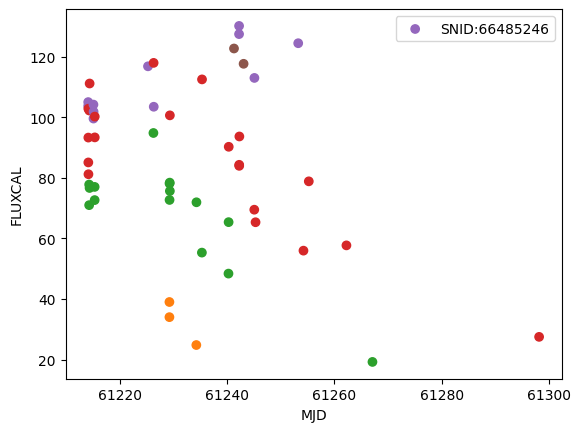

In [14]:
color_dict = {
    'u':'C0',
    'g':'C1',
    'r':'C2',
    'i':'C3',
    'z':'C4',
    'Y':'C5',
}

for i in range(len(parquet)):

    # 1 where there is a detection, 0 when there isnt
    detection_idx = np.where(parquet["PHOTFLAG"][i].to_numpy() & 4096)[0]
    detection_times = parquet["MJD"][i].to_numpy()[detection_idx]
    detection_times_since_trigger = detection_times - min(detection_times)

    n_detections_within_1_day = len(np.where(detection_times_since_trigger<1)[0])
    
    if n_detections_within_1_day>threshold:
        print("SNID: ", parquet["SNID"][i])
        print(n_detections_within_1_day)

        flux = parquet["FLUXCAL"][i].to_numpy()[detection_idx]
        detection_times = parquet["MJD"][i].to_numpy()[detection_idx]
        c = [color_dict[a] for a in parquet["BAND"][i][detection_idx]]

        print(detection_times)
        plt.scatter(detection_times, flux, marker="o", c=c, label="SNID:"+str(parquet["SNID"][i]))
        plt.xlabel("MJD")
        plt.ylabel("FLUXCAL")

        plt.legend()
        
        plt.plot()
    # print("TIMES", )
    # print(detection_idx)

In [15]:
j = np.array([sum(a) for a in x1[:, :, 1]])

0.018996173134575797


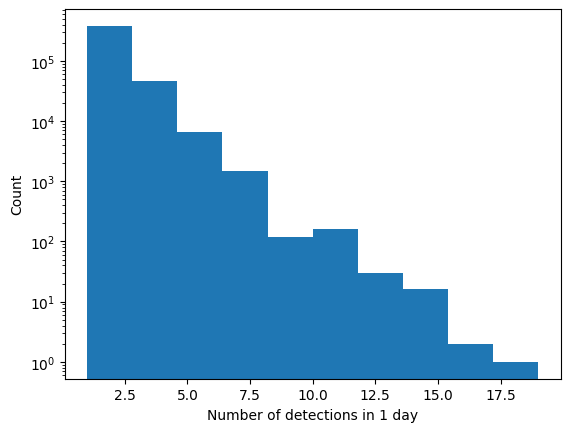

In [16]:
print(len(np.where(j>4)[0])/len(j))
plt.xlabel('Number of detections in 1 day')
plt.ylabel('Count')
plt.hist(j)
plt.yscale('log')
plt.show()